Import Necessary Packages

In [13]:
import cluster_freq
import generate_clusters
import generate_plotly
import get_matches
import json
import matplotlib.pyplot as plt
import networkx as nx
import network_graph
import numpy as np
import pandas as pd
import plotly 
import plotly.plotly as py
from plotly.graph_objs import *
import pylab
import set_plotly_credentials as setply
from sklearn.cluster import KMeans

Read in Dataset

In [14]:
filepath = 'https://raw.githubusercontent.com/rmw647/not-that-into-you/master/Speed%20Dating%20Data.csv'
data = pd.read_csv(filepath, encoding='latin1')

Downselect columns to ones needed for analysis and create a smaller dataframe with only those columns.

In [15]:
keep_columns = ['iid','pid','match','age','sports','tvsports','exercise','dining','museums',
                'art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts',
                'music','shopping','yoga','exphappy']
bio_info = data[keep_columns]
bio_info = bio_info.dropna(how='any')

Original dataframe has 10 records for each participant (one record for each date they went on). Create a subsetted dataframe that contains only one row for participant.

In [16]:
bio_info_subset = bio_info.drop_duplicates(subset='iid')

Select out the data for particpants who matched. Create a dataframe of patching pairs and a list of edges with data (person1,  person2).

In [17]:
matches, edges = get_matches.get_matches(bio_info)

Perform K-means clustering. No need to normalize because all data used is on the same scale (1- 10). We ran for several different numbers of clusters, and found 3 was a manageable number that still offered granularity.

Add a column to the subsetted data that shows the cluster assignment for each participant.

In [18]:
cluster_columns = ['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
                   'reading','tv','theater','movies','concerts','music','shopping','yoga','exphappy']
number_of_clusters = 4
bio_info_subset = generate_clusters.generate_clusters(bio_info_subset, cluster_columns, 
                                                      number_of_clusters,'cluster_assignment')

/Users/laurenwilliams/Documents/capstone/not-that-into-you/generate_clusters.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Create and plot a network graph showing the interactions within and between clusters of people.

In [19]:
G, clusters = network_graph.network_graph(bio_info_subset, edges, "circles", number_of_clusters)

In [20]:
setply.set_plotly_credentials('credentials.json')

In [21]:
awesome_plot = generate_plotly.generate_plotly(G, clusters)

In [22]:
awesome_plot

Do people within the same cluster match with each other more frequently than they match with people in other clusters? Make a plot showing how often people match within cluster and outside cluster.

In [28]:
def cluster_freq(clusters, matches):
    """Creates bar chart showing number of matches within clusters

    Parameters
    ----------
    cluster: dictionary with cluster (id, cluster_id)
    matches: list of matches (id, partner_id)

    Returns
    -------
    None
    """

    new = pd.DataFrame.from_dict(clusters, orient='index').reset_index()
    new.rename(columns={'index': 'iid', 0: 'cluster'}, inplace=True)
    together = pd.merge(new,matches,left_on=new.iid,right_on=matches.iid,
                        how='right')
    together2 = pd.merge(together,new,left_on=together.pid,right_on=new.iid,
                        how='left')
    together2 = together2.groupby(['iid_x', 'iid']).last()
    together2['same cluster'] = together2.cluster_x-together2.cluster_y
    together2[together2['same cluster'] != 0] = 'Different Clusters'
    together2[together2['same cluster'] == 0] = 'Same Cluster'
    together2['same cluster'].value_counts().plot(kind='bar')
    
    plt.show()

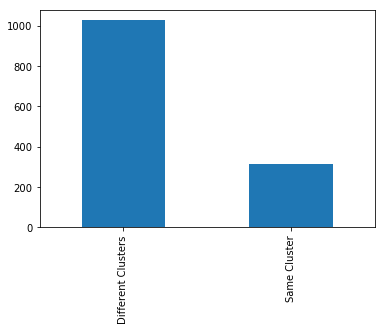

In [30]:
cluster_freq(clusters,matches)

In [24]:
cluster_sizes = cluster_freq.get_cluster_size(bio_info_subset)
cluster_sizes

{'cluster0': 152, 'cluster1': 146, 'cluster2': 117, 'cluster3': 127}

In [25]:
profiles = bio_info_subset.groupby(['cluster_assignment']).mean()
profiles.drop(['pid','iid'], inplace=True,axis=1)

In [27]:
profiles

,match,age,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy
cluster_assignment,,,,,,,,,,,,,,,,,,,,
0,0.138158,25.907895,7.414474,5.756579,6.447368,6.907895,4.888158,4.302632,4.756579,4.394737,5.815789,6.671053,5.500000,4.723684,7.052632,5.546053,7.243421,4.907895,2.638158,5.611842
1,0.164384,25.691781,7.650685,6.390411,7.294521,8.630137,8.075342,7.917808,6.924658,5.047945,6.342466,7.821918,6.746575,7.979452,8.630137,8.075342,8.561644,7.041096,5.952055,6.041096
2,0.145299,26.452991,3.299145,2.658120,4.897436,8.435897,7.811966,7.615385,4.461538,2.957265,5.991453,8.282051,6.042735,8.196581,8.623932,7.188034,8.111111,7.008547,4.752137,4.692308
3,0.149606,27.582677,6.622047,2.763780,6.251969,7.212598,7.433071,7.267717,6.763780,2.645669,4.748031,8.007874,2.826772,6.472441,7.401575,6.669291,7.622047,3.511811,4.448819,5.535433


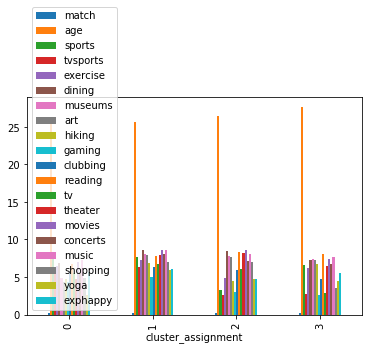

In [26]:
%matplotlib inline
profiles_subset=profiles[['sports','cluster_assignment','exercise','dining','muse]]
profiles_subset.plot(kind = 'bar')

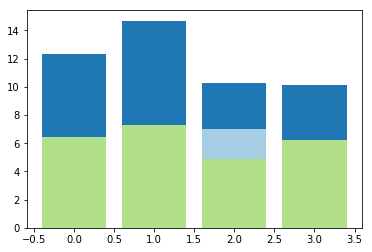

In [47]:
plt.bar(profiles.index, profiles.shopping, color = '#a6cee3')
plt.bar(profiles.index, profiles.sports, color = '#1f78b4', bottom = profiles.shopping)
plt.bar(profiles.index, profiles.exercise, color = '#b2df8a')
#plt.bar(profiles.index, profiles.museums, color = '#fb9a99', bottom = profiles.shopping)
#plt.bar(profiles.index, profiles.gaming, color = '#e31a1c', bottom = profiles.shopping)
#plt.bar(profiles.index, profiles.clubbing, color = '#fdbf6f', bottom = profiles.shopping)
#plt.bar(profiles.index, profiles.reading, color = '#ff7f00', bottom = profiles.shopping)
#plt.bar(profiles.index, profiles.exphappy, color = '#cab2d6', bottom = profiles.shopping)
#plt.bar(profiles.index, profiles.concerts, color = '#6a3d9a', bottom = profiles.shopping)
#plt.xticks(np.arange(0, number_of_clusters, 1.0))
plt.show()